In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.7em; }
</style>

In [1]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
from scipy import fftpack
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams, patches
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
#rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='500px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

def clean_4_audio(y):
    if np.amax(np.absolute(y)) > 1.:
        return y/np.amax(np.absolute(y))
    else:
        return np.concatenate((y, [1, -1]))

### Universidad Austral de Chile 

## INFO183: Análisis de sistemas lineales

# Unidad 4: Sistemas y filtros adaptivos

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


***
<a id="index"></a>

# Contenidos de la unidad

***

1. [Estimador lineal óptimo](#section1)
1. [Gradiente descendente estocástico](#section2)
1. Algoritmo de mínimos cuadrados (LMS)
1. Algoritmo de mínimos cuadrados recursivo (RLS)

# Introducción
***

- **Estimador:** Sistema diseñado para **extraer información** a partir de una **señal**
- La señal contiene **información y ruido** 
- La señal es representada como una secuencia de **datos**

Tipos de estimador
- **Filtro:** Estimo el valor actual de mi señal acentuando o eliminando una o más características
- **Predictor:** Estimo el valor futuro de mi señal

Estimador lineal óptimo
- Lineal: La cantidad estimada es una función lineal de la entrada
- Óptimo: El estimador es la mejor solución posible de acuerdo a un criterio (*e.g.* Error cuadrático medio)

Estimador lineal adaptivo
- Es lineal pero no LTI
- Sus parámetros cambian en función del tiempo
- Diseñamos una regla para actualizar sus parámetros
- Usualmente las reglas están basadas en criterios de optimización

## Proceso aleatorio/estocástico
***

- Colección de variables aleatorias indexadas en el tiempo
- Evolución de un fenomeno estadístico en el tiempo
- El fenomeno se rige por leyes probabilísticas


Un proceso aleatorio $U_n = (u_n, u_{n-1}, u_{n-2}, \ldots, u_{n-L})$ se describe a través de sus momentos

Si consideramos una caracterízación de segundo orden necesitamos definir
- Momento central o media 
$$
\mu(n) = \mathbb{E}[U_n]
$$
- Segundo momento o correlación
$$
r_{uu}(n, n-k) = \mathbb{E}[U_n U_{n-k}]
$$
- Segundo momento centrado o covarianza
$$
\begin{align}
c_{uu}(n, n-k) &= \mathbb{E}[(U_n-\mu_n) (U_{n-k}- \mu_{n-k})] \nonumber \\
&= r(n,n-k) - \mu_n \mu_{n-k} \nonumber
\end{align}
$$
- y correlación cruzada entre dos procesos 
$$
r_{ud}(n, n-k) = \mathbb{E}[U_n D_{n-k}]
$$
***
En general consideraremos el caso simplificado donde el proceso es estacionario

$$
\mu(n)  = \mu, \forall n
$$
y
$$
r_{uu}(n, n-k)  = r_{uu}(k), \forall n
$$
es decir los estadísticos se mantienen constantes en el tiempo (no depende de $n$)

Otra simplificación es que el proceso sea ergódico

$$
\mathbb{E}[U_n] = \frac{1}{N} \sum_{n=1}^N u_n
$$

es decir podemos reemplazar el valor esperado por la media en el tiempo
***

[&larr; Volver al índice](#index)

***
<a id="section1"></a>

# Estimadores óptimos
***
[Óptimo](http://dle.rae.es/?id=R7bbor7): adj. Sumamente bueno, que no puede ser mejor.

Para diseñar un estimador óptimo necesitamos un **criterio**

Luego el estimador será **óptimo según dicho criterio**

Usualmente también consideramos supuestos. Podríamos asumir que
- el ruido es aditivo y blanco o que tiene una cierta covarianza conocida
- conocemos la media y covarianza de la señal
- el proceso es estacionario



## Filtro de Wiener

- Filtro LTI de tiempo discreto
- Estructura FIR con $L+1$ coeficientes: $h_0, h_1, h_2, \ldots, h_{L}$
- La entrada es una señal $u_0, u_1, u_2, \ldots$
- Para cada tiempo el filtro produce una salida $y_0, y_1, y_2, \ldots$

Adaptamos los coeficientes del filtro con dos ingredientes
- Una respuesta "deseada" $d_0, d_1, d_2, \ldots$
- Un criterio de optimalidad que opera sobre el error entre la respuesta deseada y la salida
$$
e_n = d_n - y_n = d_n - \sum_{k=0}^{L} h_k u_{n-k} 
$$

Diagrama del filtro de Wiener

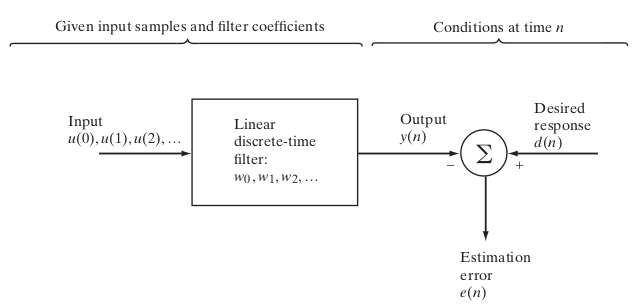

(Este filtro fue publicado por Norbert Wiener en 1949)

## Ajuste del filtro de Wiener

El criterio más común para adaptar el filtro de Wiener es **el error medio cuadrático** entre la respuesta deseada y la salida del filtro. Asumiendo que la $u$ e $d$ son secuencias reales

$$
\begin{align}
\text{MSE} &= \mathbb{E}\left [e_n^2 \right] \nonumber \\
&= \mathbb{E}\left [(d_n - y_n)^2 \right] \nonumber \\
&= \mathbb{E}\left [d_n^2 \right]  - 2\mathbb{E}\left [ d_n y_n \right] + \mathbb{E}\left [ y_n^2 \right] \nonumber 
\end{align}
$$
donde $\sigma_d^2 = \mathbb{E}\left [d_n^2 \right]$ es la varianza de la señal deseada y $\sigma_y^2 = \mathbb{E}\left [ y_n^2 \right]$ es la varianza de nuestro estimador
 
***
Minimizar el MSE implica acercar la salida del filtro a la respuesta deseada
***
En este caso igualando la derivada del MSE a cero tenemos 

$$
\begin{align}
\frac{d}{d h_j} \text{MSE} &= -2\mathbb{E}\left[ d_n \frac{d y_n}{d h_j}  \right]  + 2 \mathbb{E}\left[ y_n \frac{d y_n}{d h_j}    \right]  \nonumber \\
&= -2\mathbb{E}\left[ d_n u_{n-j} \right]  + 2 \mathbb{E}\left[ y_n u_{n-j}    \right]  \nonumber \\
&= -2\mathbb{E}\left[ d_n u_{n-j} \right]  + 2 \mathbb{E}\left[ \sum_{k=0}^{L} h_k u_{n-k}  u_{n-j} \right] \nonumber \\
&= -2\mathbb{E}\left[ d_n u_{n-j} \right]  + 2 \sum_{k=0}^{L} h_k \mathbb{E}\left[ u_{n-k}  u_{n-j} \right] = 0 \nonumber \end{align}
$$

Si despejamos y repetimos para $j=0, \ldots, L$ obtenemos el siguiente sistema de ecuaciones

$$
\begin{align}
\begin{pmatrix}
r_{uu}(0) & r_{uu}(1) & r_{uu}(2) & \ldots & r_{uu}(L) \\
r_{uu}(1) & r_{uu}(0) & r_{uu}(1) & \ldots & r_{uu}(L-1) \\
r_{uu}(2) & r_{uu}(1) & r_{uu}(0) & \ldots & r_{uu}(L-2) \\
\vdots & \vdots & \vdots & \ddots &\vdots \\
r_{uu}(L) & r_{uu}(L-1) & r_{uu}(L-2) & \ldots & r_{uu}(0) \\
\end{pmatrix}
\begin{pmatrix}
h_0  \\
h_1  \\
h_2  \\
\vdots  \\
h_L \\
\end{pmatrix} &= 
\begin{pmatrix}
r_{ud}(0)  \\
r_{ud}(1)  \\
r_{ud}(2) \\
\vdots  \\
r_{ud}(L) \\
\end{pmatrix} \nonumber \\
R_{uu} \vec h &= R_{ud},
\end{align}
$$

que se conoce como las ecuaciones de Wiener-Hopf. 

Además $R_{uu}$ se conoce como matriz de auto-correlación. Asumiendo que $R_{uu}$ es no-singular, la **solución óptima en el sentido de mínimo MSE** es 

$$
\vec h^{*} = R_{uu} ^{-1} R_{ud}
$$

En general $R_{uu}$ es una matriz definida-positiva (su inversa existe) y el sistema puede resolverse en $\mathcal{O}(L^2)$ usando la [recursión de Levison-Durbin](https://en.wikipedia.org/wiki/Levinson_recursion)

Requisitos/supuestos de este filtro
- la salida deseada y la entrada tienen media cero, *i.e.* $\mathbb{E}[d_n] = \mathbb{E}[u_n] = 0$ (si existe podemos restarla)
- la salida deseada y la entrada son estacionarias en el sentido amplio, *i.e.* la correlación solo depende de $m$

## Error mínimo del filtro de Wiener

Dado que $y_n = \vec h^T U_n = U_n^T \vec h$, podemos expresar el MSE como
$$
\begin{align}
\text{MSE} &= \mathbb{E}\left [d_n^2 \right]  - 2\mathbb{E}\left [ d_n y_n \right] + \mathbb{E}\left [ y_n^2 \right] \nonumber \\
&= \mathbb{E}\left [d_n^2 \right] - 2 \vec h^T \mathbb{E}\left [ d_n U_n \right]  + \vec h^T \mathbb{E}\left [U_n U_n^T \right]  \vec h \nonumber \\
&= \sigma_d^2 - 2 \vec h^T R_{ud} + \vec h^T R_{uu} \vec h \nonumber \\
\end{align}
$$

Luego el mínimo error que se puede obtener es

$$
\begin{align}
\text{MSE}_{\text{min}} &= \sigma_d^2 - (R_{uu}^{-1} R_{ud})^T R_{ud} \nonumber \\
&= \sigma_d^2 - R_{ud}^T R_{uu}^{-1} R_{ud} < \sigma_d^2
\end{align}
$$

# Filtro de Wiener: Eliminar ruido blanco aditivo

En este caso asumimos que la señal de entrada corresponde a una señal deseada (información) que ha sido contaminada con ruido aditivo

$$
u_n = d_n + \nu_n,
$$

adicionalmente asumimos que
- el ruido es estacionario en el sentido amplio y de media cero $\mathbb{E}[\nu_n] = 0$
- el ruido es blanco, es decir no tiene correlación consigo mismo o con la señal deseada
$$
r_{\nu d}(k) = 0, \forall k
$$
- el ruido tiene una cierta varianza $\mathbb{E}[\nu_n^2] = \sigma_\nu^2, \forall n$

Notemos que en este caso $R_{uu} = R_{dd} + R_{\nu\nu}$ y $R_{ud} = R_{dd}$, luego

la señal recuperada es $\hat d_n = h^{*} u_n$ y el filtro es

$$
\vec h^{*} = \frac{R_{dd}}{R_{dd} + R_{\nu\nu}}
$$

y su respuesta en frecuencia

$$
H(f) = \frac{S_{dd}(f)}{S_{dd}(f) + S_{\nu\nu}(f)}
$$

es decir que 
- en frecuencias donde la $S_{dd}(f) > S_{\nu\nu}(f)$, entonces $H(f) = 1$
- en frecuencias donde la $S_{dd}(f) < S_{\nu\nu}(f)$, entonces $H(f) = 0$

https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-011-introduction-to-communication-control-and-signal-processing-spring-2010/readings/MIT6_011S10_chap11.pdf

https://web.stanford.edu/class/archive/ee/ee264/ee264.1072/mylecture12.pdf

# Filtro de wiener: Predicción lineal

# Sistemas adaptivos

Hasta ahora hemos estudiando sistemas LTI: 
- sus coeficientes quedan fijos luego del diseño y son constantes en el tiempo
- hacen supuestos sobre los estadísticos de la señal/ruido

Qué hacer si
- no podemos hacer supuestos sobre los estadísticos
- los estadísticos de la señal/ruido cambian en el tiempo (no estacionaridad)

Estimador **adaptivo**: Sistemas cuyos coeficientes se pueden adaptar a medida que llegan nuevos datos




[&larr; Volver al índice](#index)

***
<a id="section2"></a>

# Gradiente descendente estocástico 
***

<IPython.core.display.Javascript object>


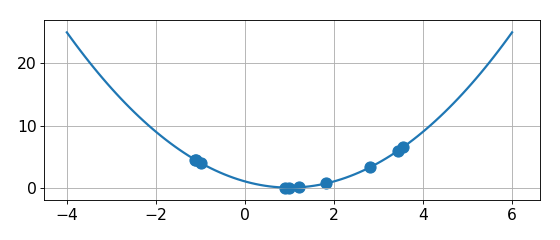

In [40]:
plt.close('all'); fig, ax = plt.subplots(1, figsize=(7, 3))
x = np.linspace(-4, 6, num=100)
L = lambda x : (x-1)**2 #+ 3*np.sin(np.pi*x)
p = 10*np.random.rand(10) - 4.
ax.plot(x, L(x))
sc = ax.scatter(p, L(p), s=100)
mu = 0.01

def update(n):
    p = sc.get_offsets()[:, 0]
    p = p - mu*2*(p-1) #- mu*3*np.pi*np.cos(np.pi*p)
    sc.set_offsets(np.c_[p, L(p)])
    
anim = animation.FuncAnimation(fig, update, frames=100, interval=200, repeat=False, blit=True)
#plt.close(); HTML(anim.to_html5_video())

***

<a id="section1"></a>

# Detección y comparación de señales en el tiempo

***



https://www.commsp.ee.ic.ac.uk/~mandic/SE_ASP_LN/ASP_MI_Lecture_5_Adaptive_Filters_2017.pdf


http://www.cnel.ufl.edu/news/invited_talks/principe2011_asilomar.pdf

http://www1.ece.neu.edu/~erdogmus/publications/J043_SPM_ITLreview.pdf

http://www.cs.tut.fi/~tabus/course/ASP/LectureNew10.pdf

https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/14-Adaptive-Filtering.ipynb?viewer=share

https://www.eit.lth.se/fileadmin/eit/courses/ett042/CE/CE5e.pdf

http://www.ee.cityu.edu.hk/~hcso/it6303_4.pdf

https://www.sparkfun.com/news/2208

http://blog.audio-tk.com/2017/03/28/audio-toolkit-recursive-least-square-filter-adaptive-module/

https://www.dummies.com/education/science/science-engineering/analysis-and-design-of-the-fir-and-iir-notch-filters/

https://stackoverflow.com/questions/35565540/designing-an-fir-notch-filter-with-python

http://www.cs.tut.fi/~tabus/course/ASP/Lectures_ASP.html

https://www.commsp.ee.ic.ac.uk/~mandic/LMS_Kalman_IEEE_SPM_2015.pdf

homes.esat.kuleuven.be/~tvanwate/courses/.../DSP2_slides_04_adaptievefiltering.pdf

https://pdfs.semanticscholar.org/aa48/98919244e59159bd276109b10dfbaa5dedf1.pdf




    Modelado de señales
    Algoritmo Least Mean Squares (LMS)
    Cancelación de ruido y eco, Ecualización adaptiva
    Algoritmo Recursive Least Squares (RLS)
    Filtro de Kalman
    
    https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html
    
    
    Algoritmos KLMS y KRLS
